In [9]:
# 基于GRU的seq2seq模型架构实现翻译的过程:

# 第一步: 导入必备的工具包.
# 第二步: 对持久化文件中数据进行处理, 以满足模型训练要求.
# 第三步: 构建基于GRU的编码器和解码器.
# 第四步: 构建模型训练函数, 并进行训练.
# 第五步: 构建模型评估函数, 并进行测试以及Attention效果分析.

In [10]:
# # 第一步: 导入必备的工具包.
from io import open
import unicodedata
import re
import random
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:0")


In [11]:
# 第二步: 对持久化文件中数据进行处理, 以满足模型训练要求
#起始标志
SOS_token=0
EOS_token=1
# 将指定语言中的词汇映射成数值:
class Lang():
    def __init__(self,name):
        """初始化函数中参数name代表传入某种语言的名字"""
        # 将name传入类中 
        self.name=name
        self.word2index={}  # 初始化词汇对应自然数值的字典
        self.index2word={0:"SOS",1:"EOS"} # 初始化自然数值对应词汇的字典, 其中0，1对应的SOS和EOS已经在里面了
        self.n_words=2# 初始化词汇对应的自然数索引，这里从2开始，因为0，1已经被开始和结束标志占用了

    def addSentence(self,sentence):
        """添加句子函数, 即将句子转化为对应的数值序列, 输入参数sentence是一条句子"""
        # 根据一般国家的语言特性(我们这里研究的语言都是以空格分个单词)
        for word in sentence.split(' '):
            self.addWord(word)
    def addWord(self,word):
        """添加词汇函数, 即将词汇转化为对应的数值, 输入参数word是一个单词"""
        # 首先判断word是否已经在self.word2index字典的key中
        if word not in self.word2index:
            self.word2index[word]=self.n_words
            self.index2word[self.n_words]=word
            self.n_words+=1
# name = "eng"
# sentence = "hello I am Jay"
# eng=Lang(name)
# eng.addSentence(sentence)
# print(eng.word2index)
# print(eng.index2word)

# 字符规范化:
# 将unicode转为Ascii, 我们可以认为是去掉一些语言中的重音标记：Ślusàrski
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c)!='Mn'
    )

def normalizeString(s):
    """字符串规范化函数, 参数s代表传入的字符串"""
    # "Are you kidding me?"->are you kidding me ?
    s=unicodeToAscii(s.lower().strip())
    # 在.!?前加一个空格
    s= re.sub(r"(.!?])",r" \1",s)
    # 使用正则表达式将字符串中不是大小写字母和正常标点的都替换成空格
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
# s = "Are you kidding me?"
# nsr = normalizeString(s)
# print(nsr)

# 将持久化文件中的数据加载到内存, 并实例化类Lang 真实内存数据
data_path='./datas/translate_data/eng-fra.txt'

def readLangs(lang1,lang2):
    """读取语言函数, 参数lang1是源语言的名字, 参数lang2是目标语言的名字
    返回对应的class Lang对象, 以及语言对列表"""
    # Run!	Cours !
    lines=open(data_path,encoding='utf-8').read().strip().split('\n')# 从文件中读取语言对并以/n划分存到列表lines中
    # 对lines列表中的句子进行标准化处理，并以\t进行再次划分, 形成子列表, 也就是语言对
    pairs=[[normalizeString(s) for s in l.split('\t')] for l in lines]
    #实例化
    input_lang = Lang(lang1) #英语
    output_lang = Lang(lang2)#法语
    return input_lang, output_lang, pairs

# lang1='eng'
# lang2='fra'
# i,o,p=readLangs(lang1,lang2)
# print(i,o,p[1:9])

# 过滤出符合我们要求的语言对:
#设置组成句子中单词或者标点的最多字符个数
MAX_LENGTH=10
# 选择带有指定前缀的语言特征数据作为训练数据
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    """语言对过滤函数, 参数p代表输入的语言对, 如['she is afraid.', 'elle malade.']"""
    # p[0]代表英语句子，对它进行划分，它的长度应小于最大长度MAX_LENGTH并且要以指定的前缀开头
    # p[1]代表法文句子, 对它进行划分，它的长度应小于最大长度MAX_LENGTH
    return len(p[0].split(' '))<MAX_LENGTH and p[0].startswith(eng_prefixes)\
        and len(p[1].split(' '))<MAX_LENGTH

def filterPairs(pairs):
    return [
        pair for pair in pairs if filterPair(pair)
    ]

# 对以上数据准备函数进行整合, 并使用类Lang对语言对进行数值映射:
# 对以上数据准备函数进行整合, 并使用类Lang对语言对进行数值映射:

def prepareData(lang1,lang2):
    """数据准备函数, 完成将所有字符串数据向数值型数据的映射以及过滤语言对
        参数lang1, lang2分别代表源语言和目标语言的名字"""
    # 首先通过readLangs函数获得input_lang, output_lang对象，以及字符串类型的语言对列表
    input_lang,output_lang,pairs=readLangs(lang1,lang2)
    #过滤
    pairs = filterPairs(pairs)
    for p in pairs:
        input_lang.addSentence(p[0])
        output_lang.addSentence(p[1])
    return input_lang,output_lang,pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra')
print("input_n_words:", input_lang.n_words)
print("output_n_words:", output_lang.n_words)
print(random.choice(pairs))

##
# 将语言对转化为模型输入需要的张量
def tensorFromSentence(lang,sentence):
    """将文本句子转换为张量, 参数lang代表传入的Lang的实例化对象, sentence是预转换的句子"""
    # 对句子进行分割并遍历每一个词汇, 然后使用lang的word2index方法找到它对应的索引
    # 这样就得到了该句子对应的数值列表
    indexs = [lang.word2index[word] for word in sentence.split(' ')]
    indexs.append(EOS_token)
    return torch.tensor(indexs,dtype=torch.long,device=device).view(-1,1)#n*1形状 -1代表未知

def tensorsFromPair(pair):
    """将语言对转换为张量对, 参数pair为一个语言对"""
    input_tensor=tensorFromSentence(input_lang,pair[0])
    output_tensor=tensorFromSentence(output_lang,pair[1])
    return (input_tensor,output_tensor)#元组返回

pair = pairs[0]
pair_tensor = tensorsFromPair(pair)
print(pair_tensor)


input_n_words: 3802
output_n_words: 5713
['you re the only one who can help me.', 'vous etes le seul a pouvoir m aider.']
(tensor([[2],
        [3],
        [4],
        [1]], device='cuda:0'), tensor([[2],
        [3],
        [4],
        [1]], device='cuda:0'))


In [12]:
# 第三步: 构建基于GRU的编码器和解码器
class EncoderRNN(nn.Module):
    def __init__(self,input_size,hidden_size):
        """它的初始化参数有两个, input_size代表解码器的输入尺寸即源语言的
        词表大小，hidden_size代表GRU的隐层节点数, 也代表词嵌入维度, 同时又是GRU的输入尺寸"""
        super(EncoderRNN,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.embedding=nn.Embedding(input_size,hidden_size) #实例化，输入词表单词总数和词嵌入的维度
        self.gru=nn.GRU(hidden_size,hidden_size)
    
    def forward(self,input,hidden):
        """编码器前向逻辑函数中参数有两个, input代表源语言的Embedding层输入张量
        hidden代表编码器层gru的初始隐层张量"""
        output=self.embedding(input).view(1,1,-1)
        output,hidden=self.gru(output,hidden)
        return output,hidden

    def initHidden(self):
        """初始化隐层张量函数"""
        return torch.zeros(1,1,self.hidden_size,device=device)     

# 构建基于GRU的解码器

class DecoderRNN(nn.Module):
    def __init__(self,hidden_size,output_size):
        """初始化函数有两个参数，hidden_size代表解码器中GRU的输入尺寸，也是它的隐层节点数
        output_size代表整个解码器的输出尺寸, 也是我们希望得到的指定尺寸即目标语言的词表大小"""
        super(DecoderRNN,self).__init__()  
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.embedding=nn.Embedding(output_size,hidden_size)
        self.gru=nn.GRU(hidden_size,hidden_size)
        self.out=nn.Linear(hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1)
    
    def forward(self,input,hidden):
        """解码器的前向逻辑函数中, 参数有两个, input代表目标语言的Embedding层输入张量
        hidden代表解码器GRU的初始隐层张量"""
        output=self.embedding(input).view(1,1,-1)
        output=F.relu(output)
        output,hidden=self.gru(output,hidden)
        output=self.softmax(self.out(output[0]))

    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size,device=device)


# 构建基于GRU和Attention的解码器

class AttnDecoderRNN(nn.Module):
    def __init__(self,hidden_size,output_size,dropout_p=0.1,max_length=MAX_LENGTH):
        #hidden_size=解码器的GRU输出尺寸，隐藏层的神经元个数
        #output——size=网络输出尺寸，法文的总数
        super(AttnDecoderRNN,self).__init__()
        # 将以下参数传入类中
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        #实例化 一个Embedding层，输入参数是outsize和hiddensize
        self.embedding= nn.Embedding(self.output_size,self.hidden_size)
        #实例化第一个的注意力机制层，注意输入是2个张量的合并
        self.attn=nn.Linear(self.hidden_size*2,self.max_length)
        #实例化第二个注意力层，输入也是2个张量的和并 ，同时输出要进入gRU中
        self.attn_combine =nn.Linear(self.hidden_size*2,self.hidden_size)
        #实例化一个dropout
        self.dropout=nn.Dropout(self.dropout_p)
        #实例化GRU
        self.gru=nn.GRU(self.hidden_size,self.hidden_size)
        #实例化gru后面的线性层，也就是我们的解码器输出层.
        self.out=nn.Linear(self.hidden_size,self.output_size)


    def forward(self,input1,hidden,encoder_output):
        #1,源数据的输入张量
        #2，隐藏层张量
        #3,编码器的输出
        #对输入 进行embedding（词嵌入） 并扩展维度 embedded
        embedded=self.embedding(input).view(1,1,-1) #-1代表未知，1*1*-1 如果原有是6个 那就是1*1*6
        embedded=self.dropout(embedded)#防止过拟合
        #进行第一个注意力层
        #进行QK纵轴拼接，
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        #进行bmm  2维度->3维   (b,h,w)*(b,w,m)=（b,h,m）
        attn_applied=torch.bmm(attn_weights.unsqueeze(0),encoder_output.unsqueeze(0))
        #再次进行拼接 并降低维度
        output=torch.cat((embedded[0],attn_applied[0]),1)
        output=self.attn_combine(output).unsqueeze(0)
        output=F.relu(output)

        #激活张量与隐藏层张量一起传入到GRU中
        output,hidden=self.gru(output,hidden)
        #将结果先降为 让线性层处理层指定的输出维度 经过softmax
        output=F.log_softmax(self.out(output[0]),dim=1)
        # 返回解码器结果，最后的隐层张量以及注意力权重张量
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size,device=device)

hidden_size=25
output_size=10
input=pair_tensor[1][0]
hidden=torch.zeros(1,1,hidden_size).to(device)
encoder_output=torch.randn(10,25).to(device)
decoder=AttnDecoderRNN(hidden_size,output_size).to(device)
output,hidden,attn_weights=decoder(input,hidden,encoder_output)
print(output)

tensor([[-2.3980, -2.0859, -2.0933, -2.3383, -2.3007, -2.2799, -2.3809, -2.3246,
         -2.5344, -2.3746]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


In [13]:
# 第四步: 构建模型训练函数, 并进行训练
# teacher_forcing->可以强制将上一步结果设置成正确的输出,防止一步错步步错
techer_forcing=0.5#为什么不设置成1呢？
def train(input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,max_length=MAX_LENGTH):
    #输入：源语言输入张量/目标语言输入张量，编码器和解码器实例化对象，2者优化器，损失函数，句子最大长度

    #初始化隐藏张量
    encoder_hidden=encoder.initHidden()
    #初始化优化器梯度
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # 根据源文本和目标文本张量获得对应的长度
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # 初始化编码器输出张量，形状是max_length * encoder.hidden_size的张量
    encoder_outputs=torch.zeros(max_length,encoder.hidden_size,device=device)
    #初始化损失
    loss=0
    #循环遍历输入张量索引
    for ei in range(input_length):
        encoder_output,encoder_hidden=encoder(input_tensor[ei],encoder_hidden)
        #encoder_output三位张量 [0,0]降维到一维列表，赋值给输出张量
        # 这样encoder_outputs每一行存的都是对应的句子中每个单词通过编码器的输出结果
        encoder_outputs[ei]=encoder_output[0,0]#这里为什么不是[0][0]
        # print(encoder_output[0,0]==encoder_output[0][0])  True


    #初始化解码器的第一个输入
    decoder_input=torch.tensor([[SOS_token]],device=device)
    # 初始化解码器的隐层张量,即给最后一次编码器的隐层层张量
    decoder_hidden=encoder_hidden
    #判断是否使用教师强制
    use_teacher_forcing=True if random.random()<techer_forcing else False
    if use_teacher_forcing:
        for di in range(target_length):#进行解码
            decoder_output,decoder_hidden,decoder_attention=decoder(decoder_input,decoder_hidden,encoder_outputs)
            loss+=criterion(decoder_output,target_tensor[di])
            #因为使用了强制教师教学# 并强制将下一次的解码器输入设置为‘正确的答案’
            decoder_input=target_tensor[di]
    else:
        for di in range(target_length):
            decoder_output,decoder_hidden,decoder_attention=decoder(decoder_input,decoder_hidden,encoder_outputs)
            loss+=criterion(decoder_output,target_tensor[di])
            #but 选取最大概率值参与下一轮的输入 但同时需要判断下一个输入是否是终止符
            topvalue,topindex=decoder_output.topk(1)
            if topindex.squeeze().item() ==EOS_token:
                break
            decoder_input=topindex.squeeze(0).detach() #这里为什么不是topvalue/
            # 解码器的输入是top-k概率值对应的词的索引，表示最高概率的单词的索引
            # 而不是概率值本身。这样做的好处是可以避免由于概率值本身对模型训练的影响，
            # 从而让模型更加稳定。 
            # 我们希望解码器能够逐步预测出正确的翻译单词序列，
            # 而不是直接输出训练数据中的正确答案。

  

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item()/target_length


#时间
import time
import math
def timeSince(since):
    now=time.time()
    s=now-since
    m=math.floor(s/60)
    s-=m*60
    return '%dm %ds'%(m,s)

#调用训练函数并打印日志和制图:
import matplotlib.pyplot as  plt
def trainIters(encoder,decoder,n_iters,print_every,plot_every,learning_rate=0.01):
    start=time.time()
    plot_losses=[]
    print_loss_total=0
    plot_loss_total=0
    encoder_optimizer=optim.SGD(encoder.parameters(),lr=learning_rate)
    decoder_optimizer=optim.SGD(decoder.parameters(),lr=learning_rate)
    criterion=nn.NLLLoss()

    for iter in range(1,n_iters+1):
        training_pair= tensorsFromPair(random.choice(pairs))
        input_tensor=training_pair[0]
        target_tensor=training_pair[1]
        # 通过train函数获得模型运行的损失
        loss=train(input_tensor=input_tensor,
                    target_tensor=target_tensor,
                    encoder=encoder,
                    decoder=decoder,
                    encoder_optimizer=encoder_optimizer,
                    decoder_optimizer=decoder_optimizer,
                    criterion=criterion
                    )

        print_loss_total+=loss
        plot_loss_total+=loss
        # 当迭代步达到日志打印间隔时
        if iter % print_every == 0:
            # 通过总损失除以间隔得到平均损失
            print_loss_avg = print_loss_total / print_every
            # 将总损失归0
            print_loss_total = 0
            # 打印日志，日志内容分别是：训练耗时，当前迭代步，当前进度百分比，当前平均损失
            print('%s (%d %d%%) %.4f' % (timeSince(start),
                                         iter, iter / n_iters * 100, print_loss_avg))

        # 当迭代步达到损失绘制间隔时
        if iter % plot_every == 0:
            # 通过总损失除以间隔得到平均损失
            plot_loss_avg = plot_loss_total / plot_every
            # 将平均损失装进plot_losses列表
            plot_losses.append(plot_loss_avg)
            # 总损失归0
            plot_loss_total = 0
    plt.figure()
    plt.plot(plot_losses)
    plt.savefig('./datas/name_data/eng-fra_loss.png')

# 设置隐层大小为256 ，也是词嵌入维度 
hidden_size=256
encoder1=EncoderRNN(input_size=input_lang.n_words,hidden_size=hidden_size).to(device=device)
attn_decoder1=AttnDecoderRNN(hidden_size=hidden_size,output_size=output_lang.n_words,dropout_p=0.1).to(device=device)



# 设置迭代步数 
n_iters = 600
# 设置日志打印间隔
print_every=50
plot_every= 50


0m 1s (50 8%) 4.7944
0m 2s (100 16%) 4.5332
0m 4s (150 25%) 4.5381
0m 5s (200 33%) 4.2048
0m 7s (250 41%) 4.4915
0m 8s (300 50%) 4.1318
0m 10s (350 58%) 4.4336
0m 12s (400 66%) 4.6152
0m 13s (450 75%) 4.2480
0m 15s (500 83%) 4.2011
0m 16s (550 91%) 4.1564
0m 18s (600 100%) 4.0098


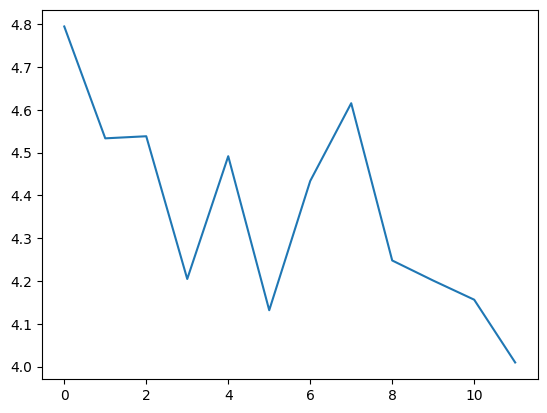

In [14]:
# 保存模型参数
# m_state_dict = torch.load('rnn.pt')
# new_m = LSTM(input_size=1, hidden_size=10, num_layers=2).to(device) 再实例化一个LSTM对像
# new_m.load_state_dict(m_state_dict)给这个新的模型传入之前加载的参数
# predict = new_m(test_tensor)
# -----保存整个模型
# torch.save(rnn, 'rnn1.pt')
# new_m = torch.load('rnn1.pt')
# predict = new_m(test_tensor)

model=trainIters(encoder=encoder1,decoder=attn_decoder1,n_iters=n_iters,print_every=print_every,plot_every=plot_every,learning_rate=0.01)
torch.save(model,'./datas/name_data/name_model.pt')
predict_model=torch.load('./datas/name_data/name_model.pt')

In [15]:
# 第五步: 构建模型评估函数, 并进行测试以及Attention效果分析.
# 构建模型评估函数:
def evaluate(encoder,decoder,sentence,max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor=tensorFromSentence(input_lang,sentence)
        input_length=input_tensor.size()[0]

        encoder_hidden=encoder.initHidden()
        encoder_outputs=torch.zeros(max_length,encoder.hidden_size,device=device)
        for ei in range(input_length):
            encoder_output,encoder_hidden=encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei]+=encoder_output[0][0]

        decoder_input=torch.tensor([[SOS_token]],device=device)
        decoder_hidden=encoder_hidden
        decoder_words=[]#预测出的词汇表
        decoder_attentions=torch.zeros(max_length,max_length)
        for di in range(max_length):
            decoder_output,decoder_hidden,decoder_attention=decoder(
                decoder_input,decoder_hidden,encoder_outputs
            )            
            decoder_attentions[di]=decoder_attention.data
            topvalue,topindex=decoder_output.data.topk(1)
            if topindex.item()==EOS_token:
                decoder_words.append('<EOS>')
                break
            else:
                decoder_words.append(output_lang.index2word[topindex.item()])
            decoder_input=topindex.squeeze().detach()
            
        return decoder_words,decoder_attention[:di+1]

def evaluateRandomly(encoder,decoder,n):
    # n代表测试数
    for i in range(n):
        pair=random.choice(pairs)
        print('输入',pair[0])
        print('正确输出',pair[1])
        output_wards,attentions=evaluate(encoder,decoder,pair[0])
        output_sentence=' '.join(output_wards)
        print('本模型预测输出',output_sentence)
        print('*'*8)

evaluateRandomly(encoder1,attn_decoder1,3)

输入 i m not presentable.
正确输出 je ne suis pas presentable.
本模型预测输出 je suis suis suis <EOS>
********
输入 we re really good.
正确输出 nous sommes vraiment bons.
本模型预测输出 il est est <EOS>
********
输入 i m busy.
正确输出 je suis occupe.
本模型预测输出 je suis suis suis <EOS>
********


il est est pas 


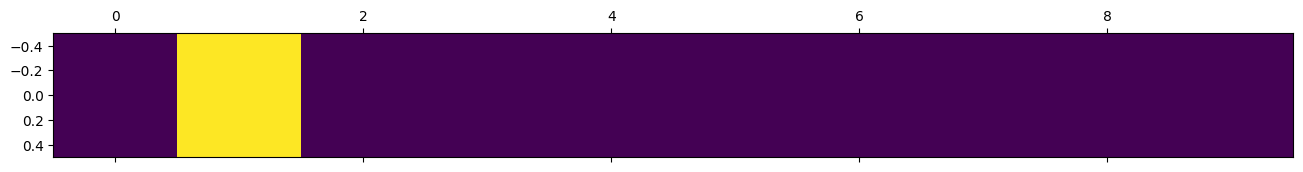

In [19]:
# Attention张量制图
sentence = "we re both teachers ."
output_words,attentions=evaluate(encoder1,attn_decoder1,sentence)
output_sentence=' '.join(output_words)
print(output_sentence[:len(output_sentence)-5])

# 将attention张量转化成numpy, 使用matshow绘制
plt.matshow(attentions.cpu().numpy())
# 保存图像
# plt.savefig("./s2s_attn.png")